### Project Details - Regression

1. Objective
2. Data Description & Cleaning
3. Baseline Models
- Linear Regression
- KNN Regressor
- XGBoost
- Model Comparison
4. Wrangling & EDA (in Phython, SQL & Tableau)
5. Data Prepocessing 
6. Applying, Validating & Displaying Predictions
- Linear Regression
- KNN Regressor
- XGBoost
- Model Comparison
7. Conclusion

In [1]:
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import xgboost as xgb
from collections import defaultdict
from scipy.stats import skew
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_excel('regression_data.xls')
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


## 1. Objective

**Objective**: 

The task is to build a model that will predict the price of a house based on features provided in the dataset. One of those parameters include understanding which factors are responsible for higher property value - \$650K and above. In short:

**“Predict selling prices of houses in King County, WA”**

## 2. Data Description & Cleaning

In [3]:
# Checking the datatypes. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [4]:
# We are exploring the categories of the different variables to confirm the datatypes assigned.
data.id.nunique()
# data.bathrooms.unique()
# data.price.unique().min()
# data.price.unique().max()
# data.view.value_counts()
# print(sorted(data.zipcode.unique()))

21420

**From a first exploration, we can derive the following information:**

- **id**: identification number for the property (21,420 properties are listed)
- **date**: date the house was sold (between May 2014 and May 2015)
- **bedrooms**: no. of bedrooms (between 1 and 33 bedrooms)
- **bathrooms**: no. of bathrooms (between 0.5 and 8 bathrooms)
- **sqft_living**: size of living area (between 370 and 13,540 sqft)
- **sqft_lot**: size of lot (between 520 and 1,651,359 sqft)
- **floors**: no. of floors (between 1 and 3.5 floors)
- **waterfront**: house which has a view to a waterfront (**1** with waterfront and **0** without)
- **view**: no. of times the house has been viewed by potential buyers (between 0 and 4 views)
- **condition**: how good the condition is (overall) (**1** indicates worn out property and **5** excellent)
- **grade**: overall grade given to the housing unit (**1** poor ,**13** excellent, properties between 3 and 13)
- **sqft_above**: square footage of house apart from basement
- **sqft_basement**: square footage of basement
- **yr_built**: year the house was built (between 1900 and 2015)
- **yr_renovated**: year the house was renovated (**0** never, or between 1934 and 2015)
- **zipcode**: zipcode of the location 
- **lat**: geographical latitude of the location
- **long**: geographical longitude of the location
- **sqft_living15**: living area in 2015 (implies previous renovations), this might have affected the lot size
- **sqft_lot15**: lot size in 2015 (implies previous renovations)
- **price**: price of the house (our target, between 78,000 and 7,700,000)

The id should be treated as a categorical value, since it is an identifier, not a discrete or continous numerical.

The zipcode will be treated as a categorical feature because we plan to use it to group or categorize properties by location (which entails other relevant factors such as demographic or socio-economic factors not provided in the dataset). We will do conversion later on.

The same applies to 'waterfront' (with or without) and 'view' (no. of views meaning interest in the property), 'condition' (rating of condition by 5 categories), and 'grade' (rating of grade from 1 to 13). They are categorical variables, but since they are already in the format of ordinal encoding/dummified, we want to use them as they are for the model.

In [5]:
# We change the datatype from int to object.
data[['id']] = data[['id']].astype(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  object        
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [6]:
# Checking for NaNs. There are none.
data.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

In [7]:
# Checking for duplicates.
duplicates = data[data.duplicated(subset='id', keep=False)]

# We add a new column 'is_duplicate' to the duplicates dataframe
duplicates['is_duplicate'] = True

if duplicates.empty:
    print("No duplicates found")
else:
    print("Duplicates found:\n", duplicates)

Duplicates found:
                id       date  bedrooms  bathrooms  sqft_living  sqft_lot  \
93     6021501535 2014-07-25         3       1.50         1580      5000   
94     6021501535 2014-12-23         3       1.50         1580      5000   
313    4139480200 2014-06-18         4       3.25         4290     12103   
314    4139480200 2014-12-09         4       3.25         4290     12103   
324    7520000520 2014-09-05         2       1.00         1240     12092   
...           ...        ...       ...        ...          ...       ...   
20654  8564860270 2015-03-30         4       2.50         2680      5539   
20763  6300000226 2014-06-26         4       1.00         1200      2171   
20764  6300000226 2015-05-04         4       1.00         1200      2171   
21564  7853420110 2014-10-03         3       3.00         2780      6000   
21565  7853420110 2015-05-04         3       3.00         2780      6000   

       floors  waterfront  view  condition  grade  sqft_above  sqft_

In our first exploration we observed the data set consists of around 21,420 properties sold between May 2014 to May 2015. There are 21,597 entries in the dataset. 

In [8]:
21597-21420

177

Hence it confirms that there are 177 duplicates based on the 'id' column. The reason here is that between May 2014 and May 2015 the same house has been sold twice, hence we need to keep both. But drop the 'id' column.

In [9]:
data.drop('id', axis=1, inplace=True)

To look closer at our objective, we check for the most important features influencing our target, the price for the properties =< 650K. And for comparison, also for the entire dataset.

In [10]:
X = data[data['price'] > 650000].drop(['price', 'date'], axis=1)
y = data[data['price'] > 650000]['price']

model = LinearRegression()
rfe = RFE(model, n_features_to_select=3)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
selected_features

Index(['waterfront', 'lat', 'long'], dtype='object')

In [11]:
X = data.drop(['price', 'date'], axis=1)
y = data['price']

model = LinearRegression()
rfe = RFE(model, n_features_to_select=3)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
selected_features

Index(['sqft_living', 'sqft_above', 'sqft_basement'], dtype='object')

Based on our Tableau map, we noticed that properties with high prices are typically located around the lake. As the distance from the lake increases, the average price per zipcode tends to decrease. These observations are supported by the results of the model, which identified the waterfront feature and the latitude/longitude coordinates as important predictors of a property's price. These features provide information about the property's location, which appears to be a key factor in determining its value.

However, running the model on the entire dataset, the resulting features show that the available living space has the main impact on the price.

In [12]:
data.to_csv('data_cleaned.csv')

## 3. Baseline Models

In [13]:
# Define the model function

def model(models, data, test_size=0.3, random_state=42, baseline=False):
    # X-y split
    X = data.select_dtypes(np.number).drop('price', axis=1)
    y = data['price']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    results = []
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        MSE = mean_squared_error(y_test, y_pred)
        RMSE = mean_squared_error(y_test, y_pred, squared=False)
        MAE = mean_absolute_error(y_test, y_pred)
        model_name = str(model).split("(")[0]
        if baseline:
            model_type = 'Baseline'
        else:
            model_type = 'Trained'
        results.append([model_name, model_type, 
                        round(r2,2), round(1-(1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2), 
                        round(MSE,2), round(RMSE,2), round(MAE,2)])
    
    df = pd.DataFrame(results, columns=['Model', 'Type', 'R2', 'Adj. R2', 'MSE', 'RMSE', 'MAE'])
    pd.set_option('display.width', 500)
    if len(models) == 1:
        print(model_type + ' Model:', model_name)
        print("R2      =", round(r2,2))
        print("Adj. R2 =", round(1-(1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2))
        print("MSE     =", round(MSE,2))
        print("RMSE    =", round(RMSE,2))
        print("MAE     =", round(MAE,2))
        plt.figure(figsize=(8, 6))
        sns.regplot(y=y_pred, x=y_test, color='green')
        plt.title('Model: ' + df['Model'][0] + '\nPredictions vs. Actual Prices')
        plt.xlabel('Property Price')
        plt.ylabel('Predicted Property Price')
        plt.show()
    else:
        print(df)
    return

### Linear Regression

Baseline Model: LinearRegression
R2      = 0.69
Adj. R2 = 0.68
MSE     = 41661369977.39
RMSE    = 204111.17
MAE     = 125639.56


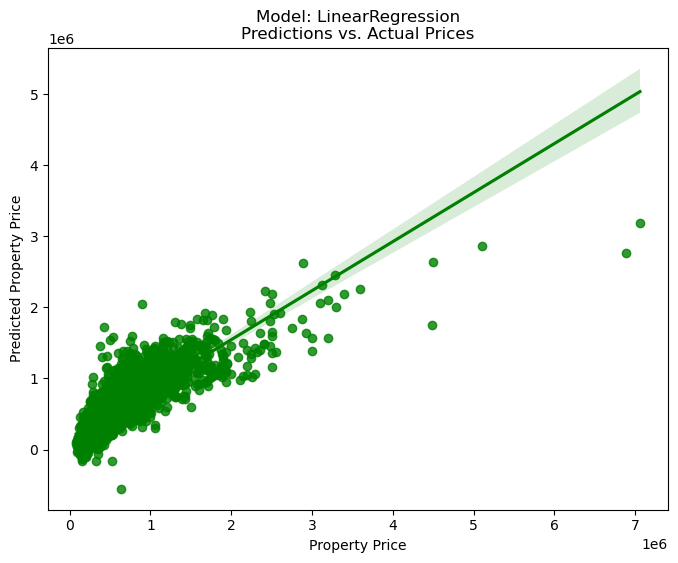

In [14]:
models = [LinearRegression()]
model(models, data, baseline=True)

In [15]:
data.price.describe().round(2)

count      21597.00
mean      540296.57
std       367368.14
min        78000.00
25%       322000.00
50%       450000.00
75%       645000.00
max      7700000.00
Name: price, dtype: float64

When considering only the R2 score of 0.69 and the lack of preprocessing, one might conclude that the model performs better than expected. However, upon closer inspection of the RMSE (204111.17), MAE (125639.56), and mean (540296.57) of the target metrics, it becomes evident that the model is not accurate.

In the scatterplot, most of the values appear to form a single cluster, except for two obvious outliers at high prices, and a few more values that are distinguishable from the rest of the cluster.

### KNN Regressor

In [16]:
# # We run the KNeighborsRegressor for values in selected intervals of a defined range.
# # It produces and returns a dataframe with evaluation metrics associated with each 'k_value' and a lineplot with the R2 values for each 'k_value'.
# # For values of `K` greater than or equal to `h`, intervals of 10 will be used, and for values of `K` less than `h`, intervals of 5 will be used during testing.

# X = data.select_dtypes(np.number).drop('price', axis=1)
# y = data['price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# def n_nbrs_comp(range, h):
#     eval_by_neighbors = defaultdict(list) 
#     k_values = []
#     run_model = False
#     for i in range:   # and now to add values to the dictionary:
#         if  i == 2:
#             run_model = True
#             model = KNeighborsRegressor(n_neighbors = i, weights = 'distance', n_jobs=-1)
#         elif i < h and i%5==0:
#             run_model = True
#             model = KNeighborsRegressor(n_neighbors = i, weights = 'distance', n_jobs=-1)
#         elif i >= h and i % 10 == 0:
#             run_model = True
#             model = KNeighborsRegressor(n_neighbors = i, weights = 'uniform', n_jobs=-1)
#         while run_model == True:
#             model.fit(X_train, y_train)
#             k_bench_pred = model.predict(X_test)
#             r2 = r2_score(y_test, k_bench_pred)
#             RMSE = mean_squared_error(y_test, k_bench_pred, squared=False)
#             MSE = mean_squared_error(y_test, k_bench_pred)
#             MAE = mean_absolute_error(y_test, k_bench_pred)
#             eval_by_neighbors['r2'].append(round(r2, 2))
#             eval_by_neighbors['RMSE'].append(round(RMSE, 2))
#             eval_by_neighbors['MSE'].append(round(MSE, 2))
#             eval_by_neighbors['MAE'].append(round(MAE, 2))
#             k_values.append(i)
#             run_model = False
#     eval_by_neighbors['K'] = k_values
#     k_metrics = pd.DataFrame(eval_by_neighbors)
#     k_metrics = k_metrics[['K', 'r2', 'RMSE', 'MSE', 'MAE']]
#     print(k_metrics)
#     comp_plot = plt.figure()
#     comp_plot = plt.figure(figsize=(15, 10))
#     plt.plot(k_metrics['K'], k_metrics['r2'], linestyle='-', marker='o', color='green', markersize=10, label='R2')
#     plt.grid()
#     plt.xticks(k_metrics.K)
#     plt.title('Baseline Model: KNeighbors Regressor' + '\n Comparison of R2 Scores for Different Numbers of Nearest Neighbors')
#     plt.xlabel("K", fontsize=15)
#     plt.ylabel("r2", fontsize=15)
#     plt.legend(loc='best')
#     plt.show()
#     return k_metrics, comp_plot

In [17]:
# k_metrics, comp_plot = n_nbrs_comp(range(2,100), 50)

For the Baseline Model KNN Regressor, we ran the baseline model with multiple values of K (nearest neighbors) and plotted the resulting R2 scores in a lineplot. We stored these values, along with metrics for RMSE, MSE, and MAE, in a separate dataframe called kbench_metrics for easy access. The lineplot showed that the highest R2 score (0.50) was achieved when K was set to 10. For K = 10, both the RMSE (257339.21) and MSE (6.622347e+10) were at their lowest, while the MAE (153236.34) was only slightly higher than its minimum value, as shown below:

In [18]:
# round(k_metrics['MAE'][2] - min(k_metrics['MAE']), 2)

Based on the K values tested above, it looks best to use 10 neighbors to run the model. Below we plot the predicted versus the tested values in a scatterplot.

Baseline Model: KNeighborsRegressor
R2      = 0.5
Adj. R2 = 0.5
MSE     = 66223470168.54
RMSE    = 257339.21
MAE     = 153236.34


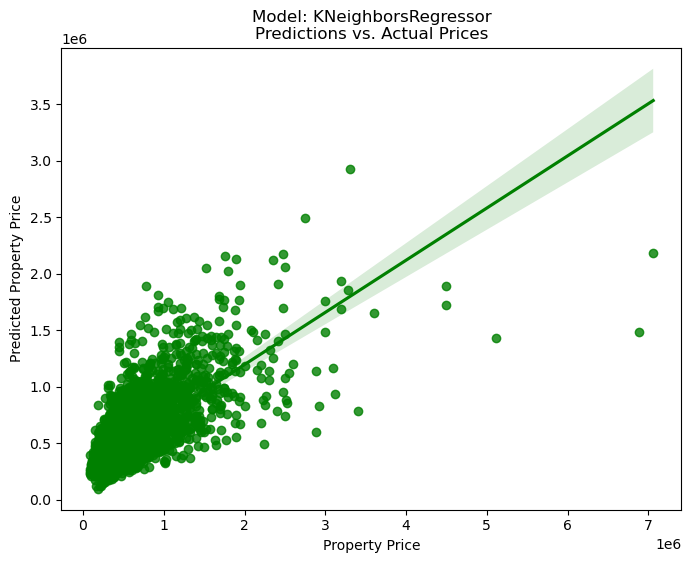

In [19]:
models = [KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)]
model(models, data, baseline=True)

### XGBoost

Baseline Model: XGBRegressor
R2      = 0.87
Adj. R2 = 0.87
MSE     = 16626170728.7
RMSE    = 128942.51
MAE     = 68088.36


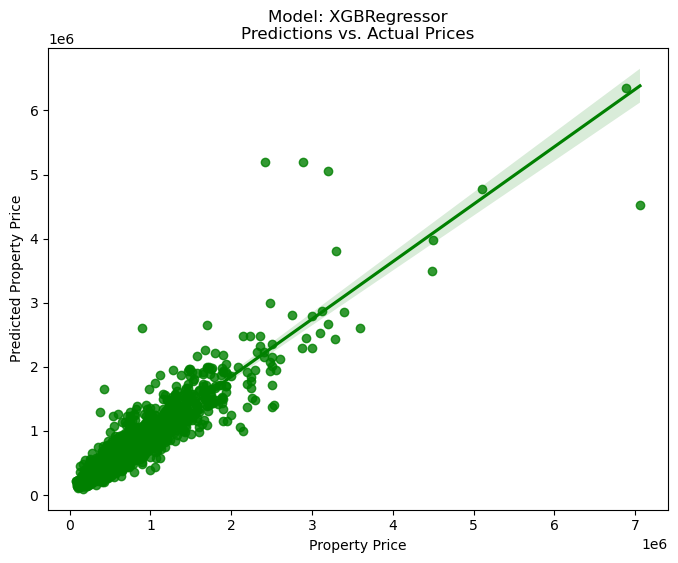

In [20]:
models = [xgb.XGBRegressor()]
model(models, data, baseline=True)

In [21]:
# # Selection of best hyperparameters for XGBoost 

# # !pip install hyperopt

# X = data.select_dtypes(np.number).drop('price', axis=1)
# y = data['price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# import hyperopt
# from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
# from xgboost import XGBRegressor
# from sklearn.model_selection import cross_val_score

# # Hyperparamters for XGBoost
# ## n_estimators: The number of trees in the model.
# ## learning_rate: The step size at each iteration while moving toward a minimum of the loss function. Smaller values generally lead to better performance but require more time to train.
# ## max_depth: The maximum depth of a tree. Deeper trees can model more complex relationships but are more prone to overfitting.
# ## subsample: The fraction of observations to be randomly sampled for each tree. Lower values can prevent overfitting but may lead to underfitting.
# ## colsample_bytree: The fraction of features to be randomly sampled for each tree. Similar to subsample, lower values can prevent overfitting but may lead to underfitting.
# ## reg_alpha: L1 regularization term on weights. Can be used to reduce overfitting.
# ## reg_lambda: L2 regularization term on weights. Can also be used to reduce overfitting.
# ## gamma: Minimum loss reduction required to make a split. Larger values result in fewer splits and can prevent overfitting.

# # Define the hyperparameter search space
# space = {
#     'n_estimators': hp.choice('n_estimators', [100, 500, 1000]), 
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),  
#     'max_depth': hp.choice('max_depth', range(3, 10)),
#     'subsample': hp.uniform('subsample', 0.8, 1),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1),
#     'reg_alpha': hp.loguniform('reg_alpha', -3, 0),
#     'gamma': hp.loguniform('gamma', -3, 0),
#     'reg_lambda': hp.loguniform('reg_lambda', -3, 0)
# }

# # Define the objective function to minimize
# def objective(params):
#     model_xgb = XGBRegressor(**params)
#     score = cross_val_score(model_xgb, X_train, y_train, cv=5).mean()
#     return {'loss': -score, 'status': STATUS_OK}

# # Run the hyperparameter search using Tree-structured Parzen Estimator (TPE)
# trials = Trials()
# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials)

# # Print the best hyperparameters and the corresponding score
# best_params = hyperopt.space_eval(space, best)
# print("Best parameters: ", best_params)
# model_xgb = XGBRegressor(**best_params)
# score = cross_val_score(model_xgb, X_train, y_train, cv=5).mean()
# print("Best score: ", score)

Baseline Model: XGBRegressor
R2      = 0.88
Adj. R2 = 0.88
MSE     = 15609322516.42
RMSE    = 124937.27
MAE     = 64350.41


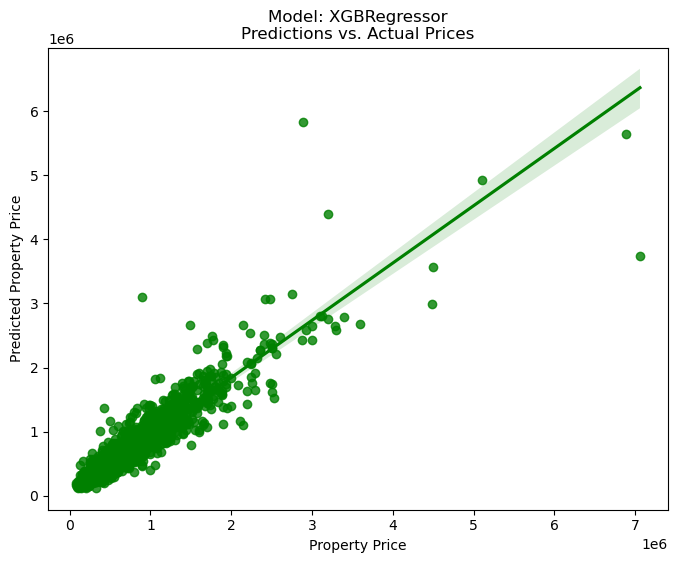

In [22]:
models = [xgb.XGBRegressor(colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=1000, 
                           reg_alpha=0, reg_lambda=0.5, subsample=1, tree_method='hist')]
model(models, data, baseline=True)

### Model Comparison

In [23]:
models = [LinearRegression(), 
          KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1), 
          xgb.XGBRegressor(colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=1000, 
                           reg_alpha=0, reg_lambda=0.5, subsample=1, tree_method='hist')]
model(models, data, baseline=True)

                 Model      Type    R2  Adj. R2           MSE       RMSE        MAE
0     LinearRegression  Baseline  0.69     0.68  4.166137e+10  204111.17  125639.56
1  KNeighborsRegressor  Baseline  0.50     0.50  6.622347e+10  257339.21  153236.34
2         XGBRegressor  Baseline  0.88     0.88  1.560932e+10  124937.27   64350.41


To summarise the results of the comparison between the 3 models, according to the precision of predictions and the evaluation metrics above, the XGBoost Model performs better than the other two models.

 ## 4. Wrangling & EDA (in Phython, SQL & Tableau)

In [24]:
#eda_report = ProfileReport(data, title = "EDA Report - Properties")
#eda_report

**`date`**: <br>The EDA report supports the previous findings. 
To evaluate the importance of the 'date' column, we will group the dates into quarters and analyze the aggregate price of houses sold in each quarter.

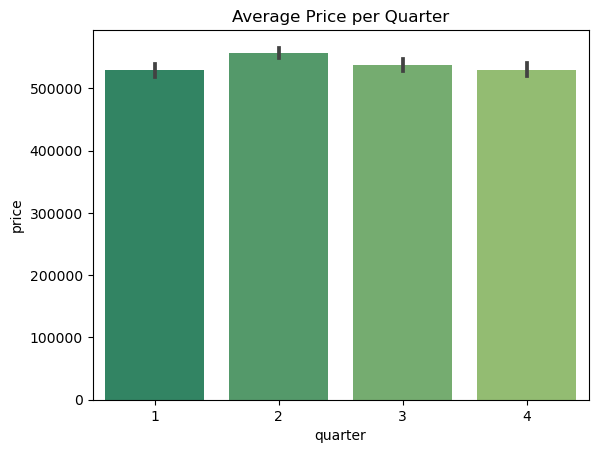

In [25]:
data['date'] = data['date'].dt.quarter
with sns.color_palette('summer'):
    sns.barplot(x = data['date'], y = data['price']).set(xlabel = 'quarter', ylabel = 'price', title = 'Average Price per Quarter')

We observe that there is barely a difference between the quarters. This confirms our thought that since we are looking only at one year of sales, the date sold is irrelevant. Hence we drop the column 'date'. 

In [26]:
data.drop('date', axis=1, inplace=True)

**`yr_built`** and **`yr_renovated`**: <br>And we clean the 'yr_renovated' since there are many zeros, which means houses have never been renovated, so the year should be the same as the 'yr_ built'. This way we fill the zeros. <br>Then we calculate the age of each property and create columns 'age_built' and 'age_renovated', and drop the two columns 'yr_built' and 'yr_renovated'.

In [27]:
# We fill zeros in yr_renovated with yr_built.
data['yr_renovated'] = data.apply(lambda row: row['yr_built'] if row['yr_renovated'] == 0 else row['yr_renovated'], axis=1)

# Then we calculate the age of each property.
current_year = datetime.datetime.now().year
data['age_built'] = current_year - data['yr_built']
data['age_renovated'] = current_year - data['yr_renovated']

In [28]:
# Test with `age` instead of `year`
models = [LinearRegression(), 
          KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1), 
          xgb.XGBRegressor(colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=1000, 
                           reg_alpha=0, reg_lambda=0.5, subsample=1, tree_method='hist')]
model(models, data.drop(['yr_built', 'yr_renovated'], axis=1))

                 Model     Type    R2  Adj. R2           MSE       RMSE        MAE
0     LinearRegression  Trained  0.69     0.68  4.166064e+10  204109.37  125628.37
1  KNeighborsRegressor  Trained  0.50     0.50  6.636149e+10  257607.23  153518.77
2         XGBRegressor  Trained  0.88     0.88  1.538246e+10  124026.05   64345.42


In [29]:
# Result is slightly better, hence we drop the columns 'yr_built' and 'yr_renovated'.
data.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

**`zipcode`**: <br>The zipcode should be treated as a categorical feature. The EDA report shows there are 70 distinct zipcodes in the dataset. So we group the zipcode based on the average price of each zipcode and change it to ordinal variable.

In [30]:
# Group the data by 'zipcode' and calculate the mean price for each group
zipcode_price_k = data.groupby('zipcode')['price'].mean().sort_values(ascending=True)/1000
zipcode_price_k

zipcode
98002     234.284035
98168     240.328372
98032     251.296240
98001     281.194870
98148     284.908596
            ...     
98102     899.607673
98112    1096.239007
98040    1194.873638
98004    1356.523991
98039    2161.300000
Name: price, Length: 70, dtype: float64

In [31]:
# We group zipcode into 6 groups.
zipcode_price = data.groupby('zipcode')['price'].mean().reset_index()
category_ranges = [200000, 400000, 600000, 800000, 1000000, 2000000, float('inf')]

categories = []
for i in range(6):
    start_price = category_ranges[i]
    end_price = category_ranges[i+1]
    category_zipcodes = list(zipcode_price[(zipcode_price['price'] >= start_price) & (zipcode_price['price'] < end_price)]['zipcode'])
    categories.append(category_zipcodes)
def get_zipcode_category(zipcode):
    for i, category in enumerate(categories):
        if zipcode in category:
            return i+1
    return -1

# Then we create a new column 'zipcode_category'.
data['zipcode_category'] = data['zipcode'].apply(get_zipcode_category)

In [32]:
# Let's test with 'zipcode_category' instead of 'zipcode'.
models = [LinearRegression(), 
          KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1), 
          xgb.XGBRegressor(colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=1000, 
                           reg_alpha=0, reg_lambda=0.5, subsample=1, tree_method='hist')]
model(models, data.drop(['zipcode'], axis=1))

                 Model     Type    R2  Adj. R2           MSE       RMSE        MAE
0     LinearRegression  Trained  0.76     0.75  3.244288e+10  180119.06  107396.32
1  KNeighborsRegressor  Trained  0.50     0.50  6.660405e+10  258077.61  154079.71
2         XGBRegressor  Trained  0.89     0.89  1.446830e+10  120284.23   63738.91


In [33]:
# The result is better, hence we drop column 'zipcode'.
data.drop(['zipcode'], axis=1, inplace=True)

**`lat`** and **`long`**: <br>Latitude and longitude combined essentially provide us with the same as the zipcode.

In [34]:
# Test without 'lat' and 'long'.
models = [LinearRegression(), 
          KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1), 
          xgb.XGBRegressor(colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=1000, 
                           reg_alpha=0, reg_lambda=0.5, subsample=1, tree_method='hist')]
model(models, data.drop(['lat', 'long'], axis=1))

                 Model     Type    R2  Adj. R2           MSE       RMSE        MAE
0     LinearRegression  Trained  0.74     0.74  3.383565e+10  183944.68  110399.17
1  KNeighborsRegressor  Trained  0.50     0.50  6.660407e+10  258077.64  154079.87
2         XGBRegressor  Trained  0.84     0.84  2.162742e+10  147062.65   80942.90


We decide to not drop lat and long, since the result is worse.

In [35]:
data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price', 'age_built', 'age_renovated', 'zipcode_category'], dtype='object')

In [36]:
data = data[['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement', 'bedrooms', 'bathrooms', 'floors', 'zipcode_category', 'lat', 'long', 'waterfront', 'view', 'condition', 'grade', 'age_built', 'age_renovated', 'price']]

Now we check imbalance and deal with high correlation and multicollinearity, also indicated by the report. 

In [37]:
# Let's check the distribution of the different variables to further understand our dataset.
data.describe().round().T

,count,mean,std,min,25%,50%,75%,max
sqft_living,21597.0,2080.0,918.0,370.0,1430.0,1910.0,2550.0,13540.0
sqft_lot,21597.0,15099.0,41413.0,520.0,5040.0,7618.0,10685.0,1651359.0
sqft_living15,21597.0,1987.0,685.0,399.0,1490.0,1840.0,2360.0,6210.0
sqft_lot15,21597.0,12758.0,27274.0,651.0,5100.0,7620.0,10083.0,871200.0
sqft_above,21597.0,1789.0,828.0,370.0,1190.0,1560.0,2210.0,9410.0
sqft_basement,21597.0,292.0,443.0,0.0,0.0,0.0,560.0,4820.0
bedrooms,21597.0,3.0,1.0,1.0,3.0,3.0,4.0,33.0
bathrooms,21597.0,2.0,1.0,0.0,2.0,2.0,2.0,8.0
floors,21597.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0
zipcode_category,21597.0,2.0,1.0,1.0,1.0,2.0,3.0,6.0


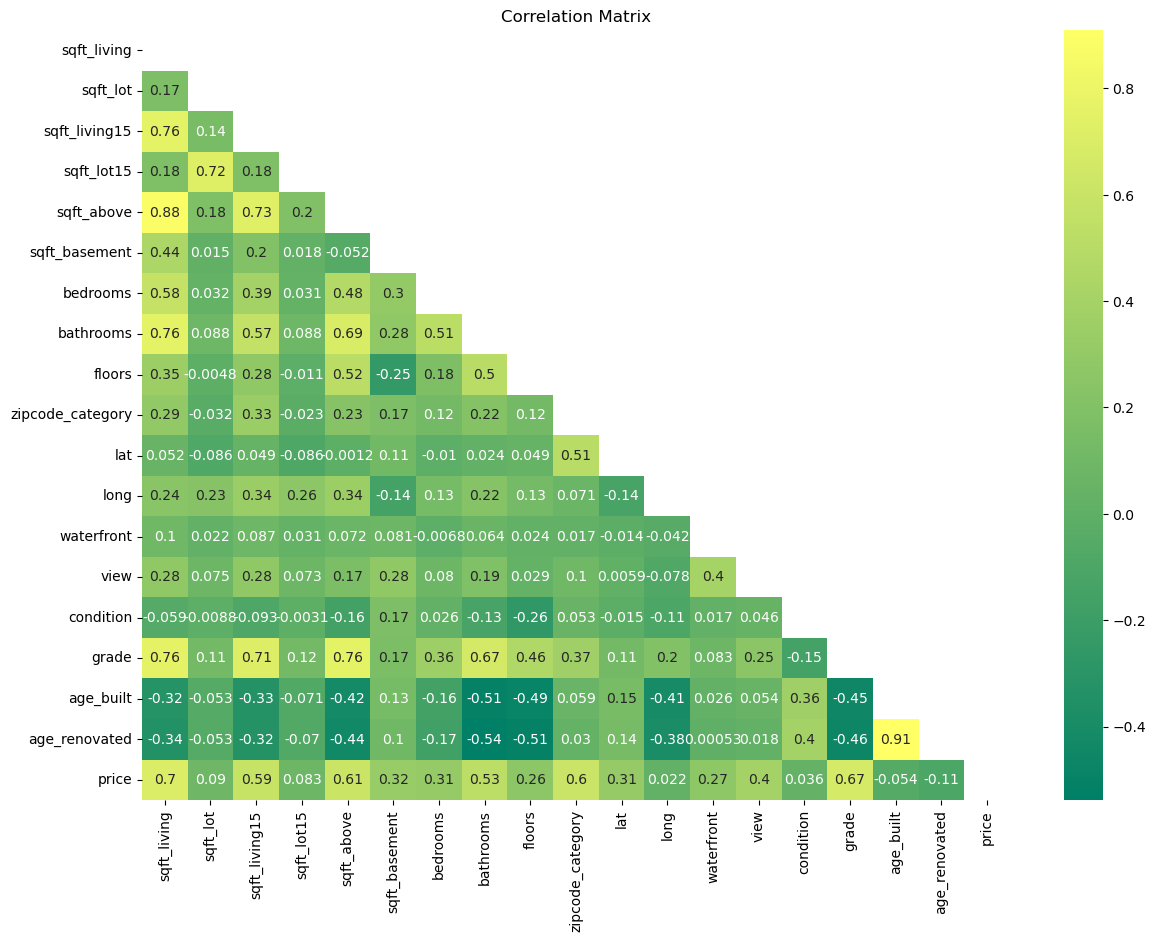

In [38]:
# We check the correlation between the numerical variables.
corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='summer')
plt.title('Correlation Matrix')
plt.show()

**Key findings from the EDA report confirmed by the heatmap:**

- sqft_living has a **high** correlation with grade (0.76), sqft_above (0.88), and sqft_living15 (0.76) and shows the overall **best** relation with the target.
- sqft_lot is **highly** correlated with sqft_lot15 (0.72). sqft_lot shows a slightly better relation with the target.
- bathrooms is **highly** correlated with sqft_living (0.76), has a medium correlation with floors, grade, sqft_above, yr_built, sqft_living15 and shows a good relation to the target.
- grade is **highly** correlated with sqft_living (as mentioned above, 0.76), sqft_above (as mentioned above, 0.76), sqft_living15 (0.71). sqft_above and sqft_living15 are also highly correlated (0.73). As well as with sqft_living (0.88 and 0.76 respectively). Of the four, sqft_living shows the best relation with the target (0.7).
- age_built is **highly** correlated with age_renovated (0,91) and viceversa.


- The target shows a good relation with sqft_living, sqft_living15, sqft_above, bathrooms, zipcode_category, and grade.

Based on these findings we want to drop the features 'sqft_living15', 'sqft_lot15', 'sqft_above', 'bathrooms', 'grade', and 'age_built'. Plotting the relations in Tableau these assumptions are mostly confirmed, e.g. we can observe that 'sqft_living' shows a better R2 score than 'sqft_living15'. We can drop 'grade' also because it provides us essentially with a similar information as 'condition' (as you can see below as well as in our Tableau Workbook).  

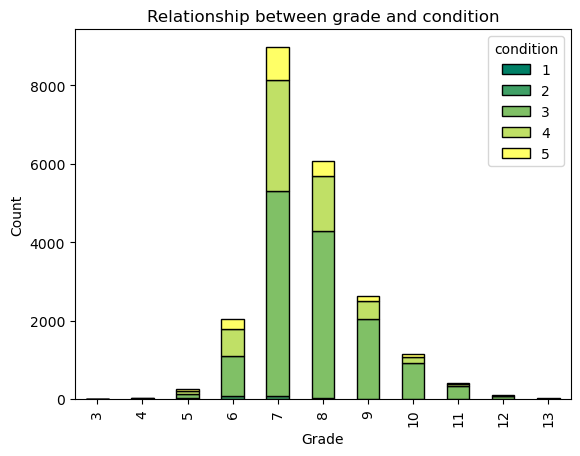

In [39]:
# We group the data by grade and condition.
grouped_data = data.groupby(['grade', 'condition']).size().unstack()

# We create a stacked bar chart.
grouped_data.plot(kind='bar', stacked=True, cmap='summer', edgecolor='black')

# And set the title and axis labels.
plt.title('Relationship between grade and condition')
plt.xlabel('Grade')
plt.ylabel('Count')

plt.show()

In [40]:
data.drop(['sqft_living15', 'sqft_lot15', 'sqft_above', 'bathrooms', 'condition', 'age_built'], axis=1, inplace=True)

In [41]:
data.columns

Index(['sqft_living', 'sqft_lot', 'sqft_basement', 'bedrooms', 'floors', 'zipcode_category', 'lat', 'long', 'waterfront', 'view', 'grade', 'age_renovated', 'price'], dtype='object')

Now we are doing a first check for outliers.

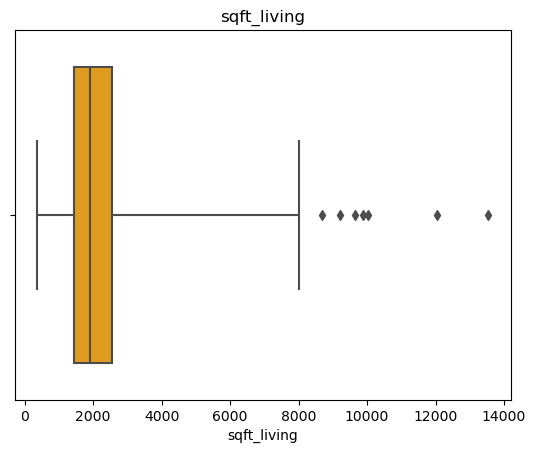

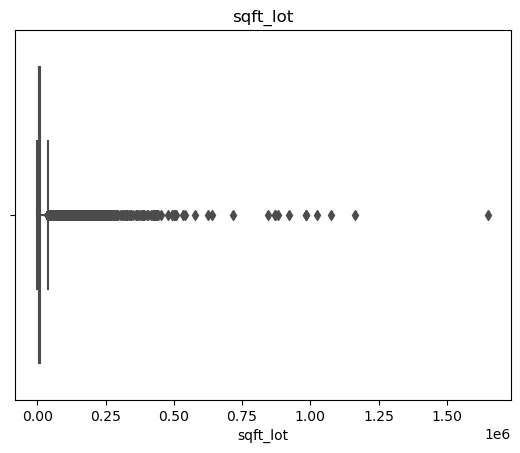

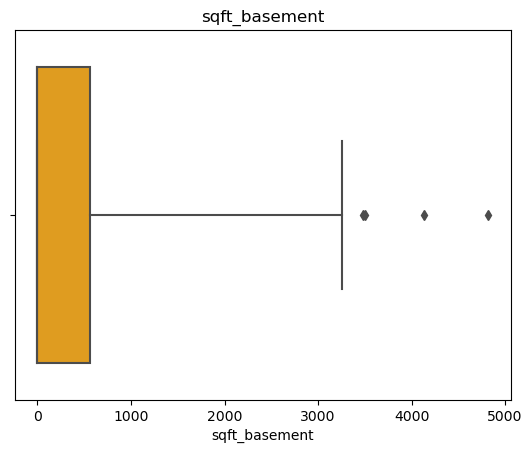

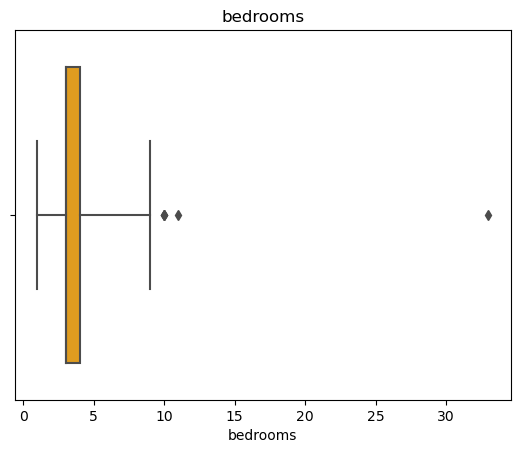

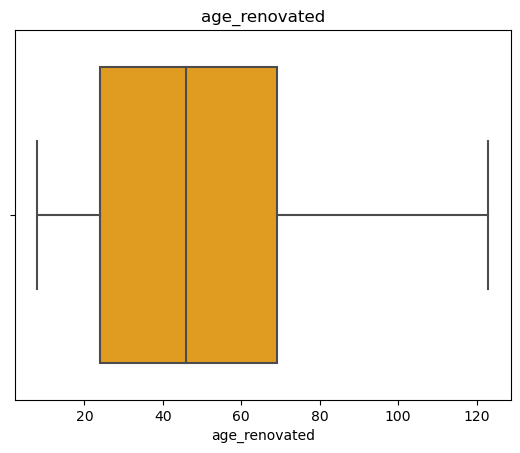

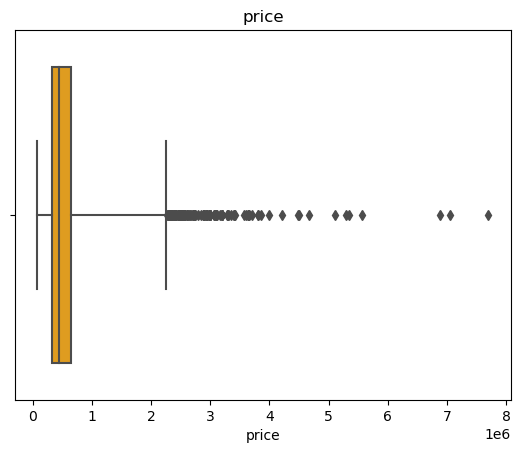

In [42]:
# To create a boxplot for the appropriate numerical columns based on prior analysis. 
cols = ['sqft_living', 'sqft_lot', 'sqft_basement', 'bedrooms', 'age_renovated', 'price']

for col in cols:
    sns.boxplot(x=data[col], whis=5, color='orange')
    plt.title(col)
    plt.show()

# We see in most of the features there's one strong and a number of other outliers.

## 5. Data Preprocessing 

In [43]:
filtered_rows = data.loc[data['sqft_lot'] == 1651359]
filtered_rows

,sqft_living,sqft_lot,sqft_basement,bedrooms,floors,zipcode_category,lat,long,waterfront,view,grade,age_renovated,price
1717,1300,1651359,0,4,1.0,1,47.2313,-122.023,0,3,6,103.0,700000


In [44]:
filtered_rows = data.loc[data['sqft_living'] == 13540]
filtered_rows

,sqft_living,sqft_lot,sqft_basement,bedrooms,floors,zipcode_category,lat,long,waterfront,view,grade,age_renovated,price
12764,13540,307752,4130,7,3.0,3,47.6675,-121.986,0,4,12,24.0,2280000


The maximum values of 'sqft_lot' and 'sqft_living' look unusual but not unproportional, meaning the n° of bedrooms, size of living and lot, grade and price go hand in hand. Nevertheless, keeping extreme values in our dataset can skew the results of our analysis and make it more difficult to identify the factors that are driving higher property values. 
Since we specifically want to understand which factors are responsible for higher property value - 650K and above - we will create a subset of our original dataset that includes only the properties with prices of 650K and above, and then analyze the relationship between the various features and the target variable (price) in this subset. The subset will include the heavy outliers in price, so we can observe whether they remain heavy in this new set.

First we remove the strongest outliers from the full dataset starting with 'bedrooms', then we move on to model the subset with higher prices.

In [45]:
data_high = data[data['price'] >= 650000]

In [46]:
data['bedrooms'].value_counts().max

<bound method NDFrame._add_numeric_operations.<locals>.max of 3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64>

In [47]:
filtered_rows = data[data['bedrooms'].isin([10, 11, 33])]
filtered_rows

,sqft_living,sqft_lot,sqft_basement,bedrooms,floors,zipcode_category,lat,long,waterfront,view,grade,age_renovated,price
8748,3000,4960,600,11,2.0,1,47.5560,-122.363,0,0,7,24.0,520000
13301,4590,10920,2090,10,1.0,5,47.5861,-122.113,0,2,9,15.0,1150000
15147,3610,11914,600,10,2.0,4,47.5705,-122.175,0,0,7,65.0,650000
15856,1620,6000,580,33,1.0,2,47.6878,-122.331,0,0,7,76.0,640000
19239,2920,3745,1060,10,2.0,4,47.6635,-122.320,0,0,7,110.0,660000


In this case, the property with 33 bedrooms is significantly different from the rest of the properties and is due to the proportionaly small 'sqft_living' most likely a data entry error. Hence we remove the outlier.

There are four properties with 10 and 11 bedrooms, they all differ in their other characteristics. However, having 10/11 bedrooms in a property with 4590 sqft or less of living space would be considered very unusual and might suggest a unique floor plan or unconventional use of the space. We will consider these rows errors and remove them as well.

In [48]:
data_processed = data[~data['bedrooms'].isin([10, 11, 33])]

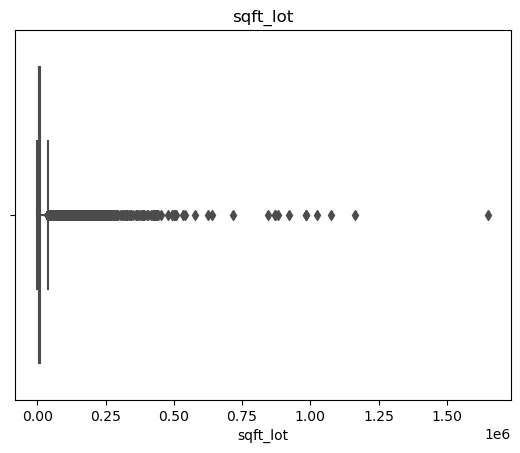

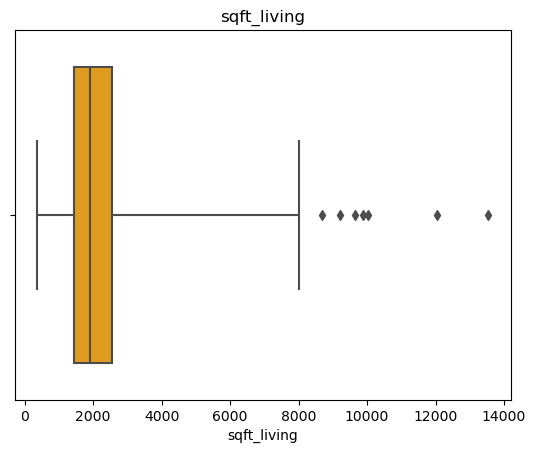

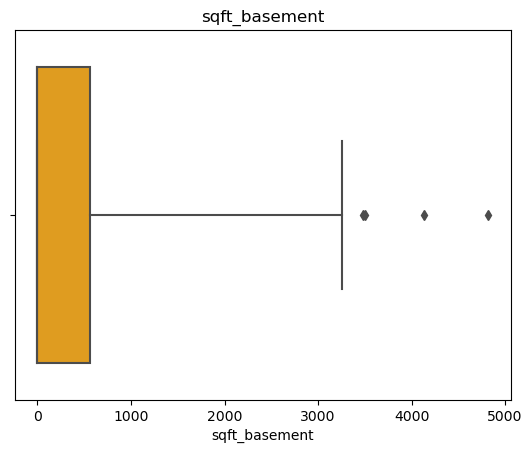

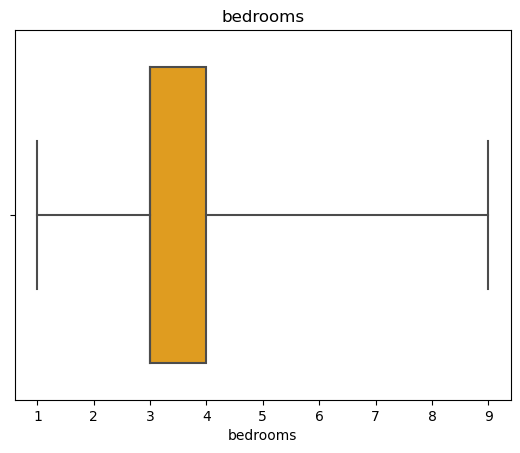

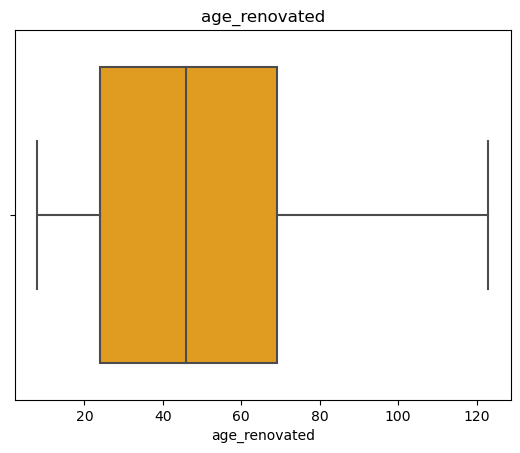

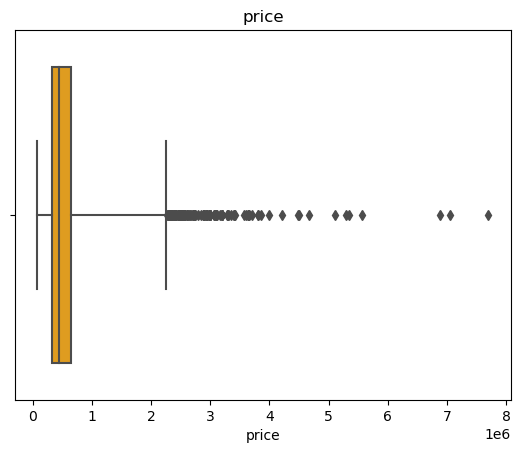

In [49]:
# Let's see if and how it affects the rest of the variables. 
cols = ['sqft_lot', 'sqft_living', 'sqft_basement', 'bedrooms', 'age_renovated', 'price']

for col in cols:
    sns.boxplot(x=data_processed[col], whis=5, color='orange')
    plt.title(col)
    plt.show()

The plot of 'sqft_lot' shows almost only "outliers" since there are a lot of properties without any lot around the house at all. Let's look at the biggest one. 

In [50]:
filtered_rows = data_processed.loc[data_processed['sqft_lot'] == 1651359]
filtered_rows

,sqft_living,sqft_lot,sqft_basement,bedrooms,floors,zipcode_category,lat,long,waterfront,view,grade,age_renovated,price
1717,1300,1651359,0,4,1.0,1,47.2313,-122.023,0,3,6,103.0,700000


A plot size of 1,651,359 sqft is certainly possible, but it is quite large and would be considered a very large property. This property is located in the southeast of King County, WA and includes the city of Enumclaw and several nearby communities. We looked at prize by location in Tableau as below. 

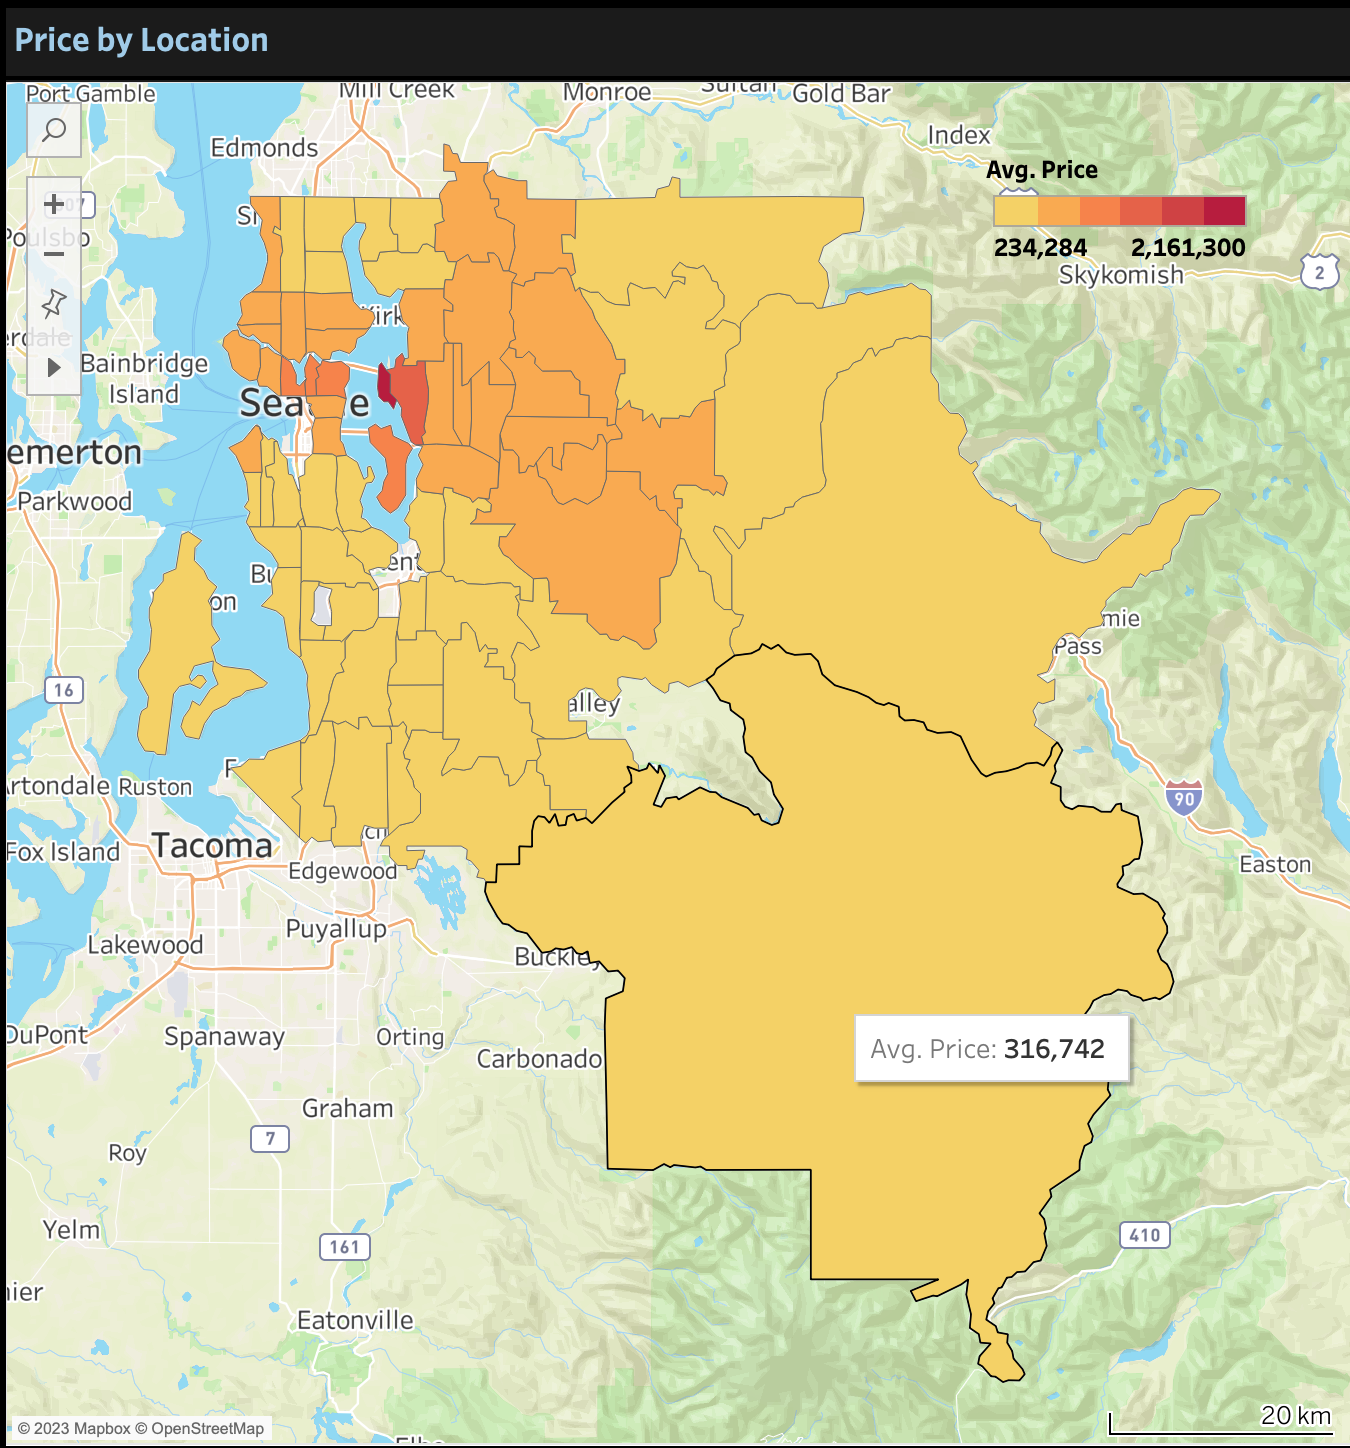

The price of 700,000 is possible in comparison to the average price of other properties in this zipcode. 
The average lot size in zipcode 98022 is around 74,600 sqft (derived from the dataset at an earlier point), hence the lot size of this outlier is comparatively large, but the zipcode contains rural areas. Based on these findings, we decide to keep this row.

We move on to reducing outliers of 'sqft_living'.

In [51]:
# We calculate the IQR to catch the outliers in 'sqft_living'. 
# We tested with different multipliers defining the upper and lower bounds to flag more or less data points as outliers. 
# The best model performance was achieved with a multiplier of 3. 
Q1 = data_processed['sqft_living'].quantile(0.25)
Q3 = data_processed['sqft_living'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
data_processed = data_processed[(data_processed['sqft_living'] >= lower_bound) & (data_processed['sqft_living'] <= upper_bound)]

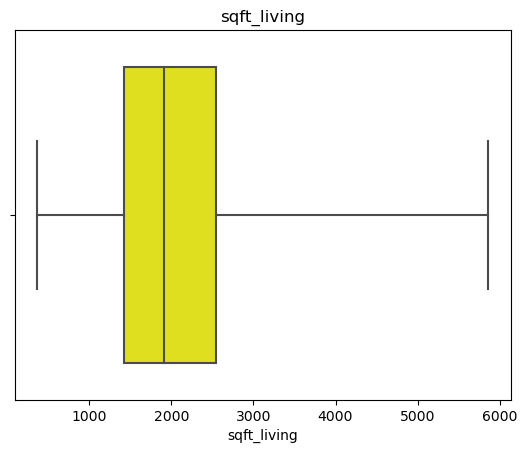

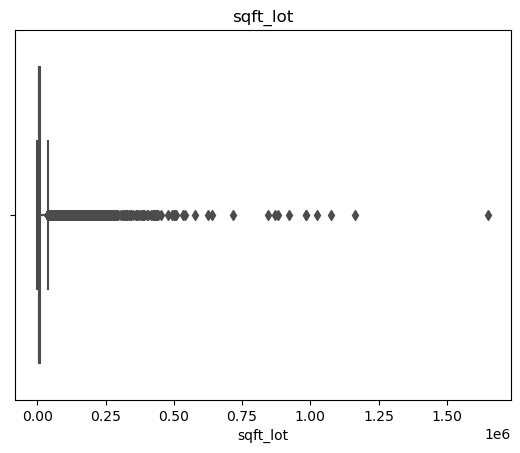

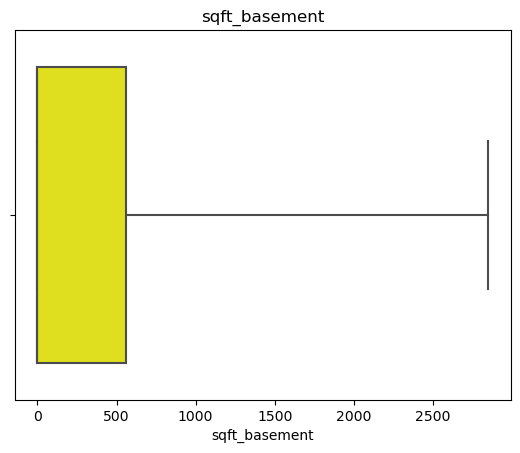

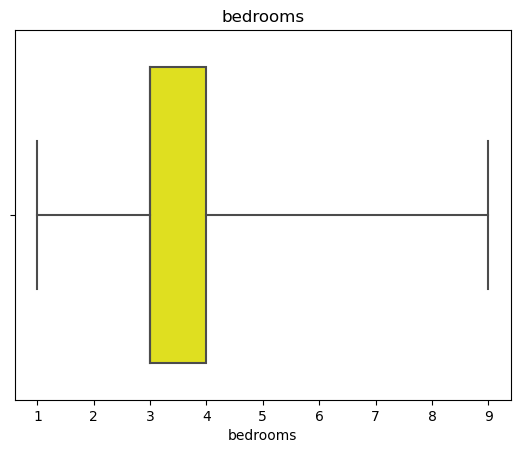

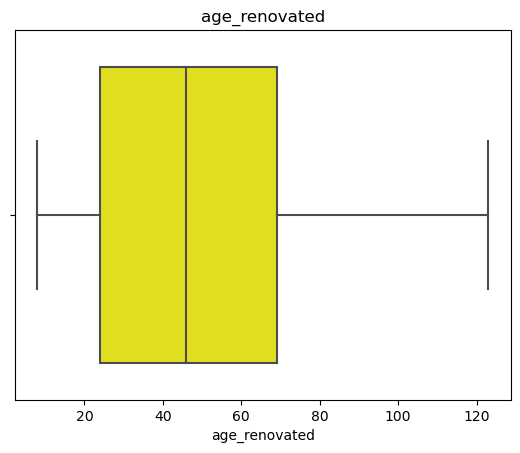

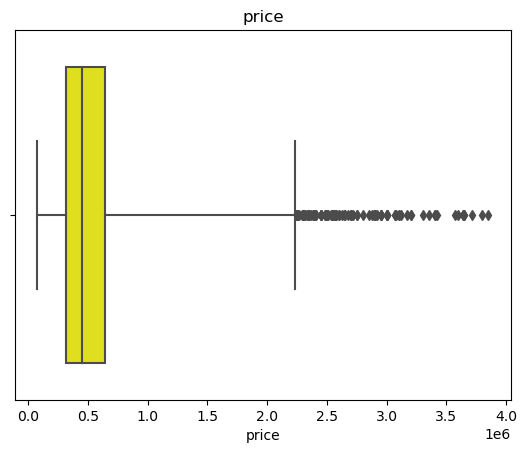

In [52]:
cols = ['sqft_living', 'sqft_lot', 'sqft_basement', 'bedrooms', 'age_renovated', 'price']

for col in cols:
    sns.boxplot(x=data_processed[col], whis=5, color='yellow')
    plt.title(col)
    plt.show()

In [53]:
data_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21518 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sqft_living       21518 non-null  int64  
 1   sqft_lot          21518 non-null  int64  
 2   sqft_basement     21518 non-null  int64  
 3   bedrooms          21518 non-null  int64  
 4   floors            21518 non-null  float64
 5   zipcode_category  21518 non-null  int64  
 6   lat               21518 non-null  float64
 7   long              21518 non-null  float64
 8   waterfront        21518 non-null  int64  
 9   view              21518 non-null  int64  
 10  grade             21518 non-null  int64  
 11  age_renovated     21518 non-null  float64
 12  price             21518 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 2.3 MB


In [54]:
data_processed.to_csv('data_processed.csv')

**Now we will look at the subset with the properties of a price equal or above 650K.**

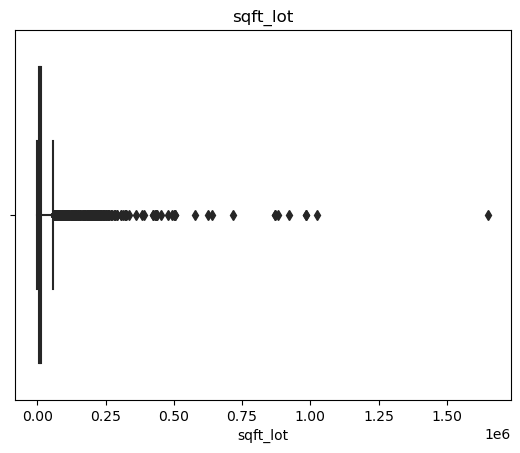

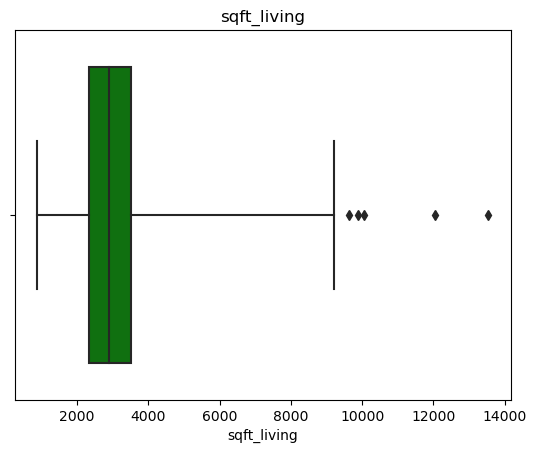

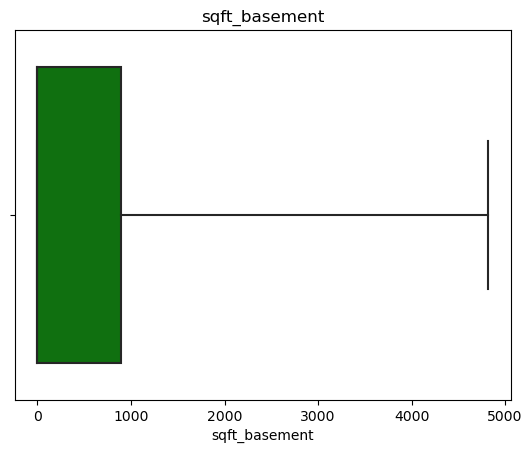

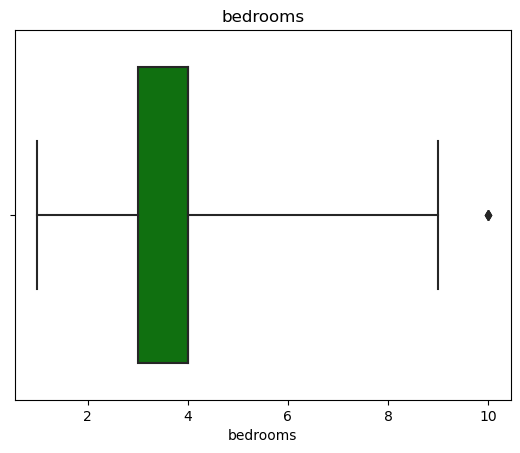

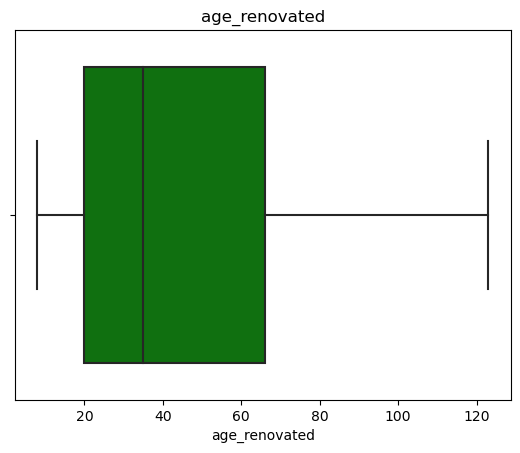

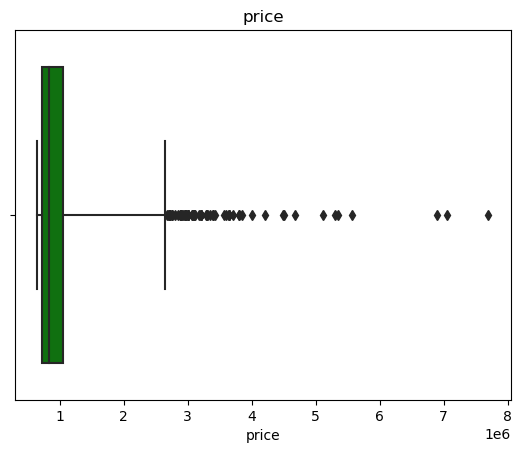

In [55]:
# Let's see how the variables behave in the subset.
cols = ['sqft_lot', 'sqft_living', 'sqft_basement', 'bedrooms', 'age_renovated', 'price']

for col in cols:
    sns.boxplot(x=data_high[col], whis=5, color='green')
    plt.title(col)
    plt.show()

Starting off, the subset looks much more coherent, there is a few outliers in the dependent variables 'bedrooms' and 'sqft_living' and heavy outliers in the independent variable which should be excluded.

In [56]:
# We calculate the IQR to catch the outlier in 'sqft_living'.
Q1 = data_high['sqft_living'].quantile(0.25)
Q3 = data_high['sqft_living'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data_high_processed = data_high[(data_high['sqft_living'] >= lower_bound) & (data_high['sqft_living'] <= upper_bound)]

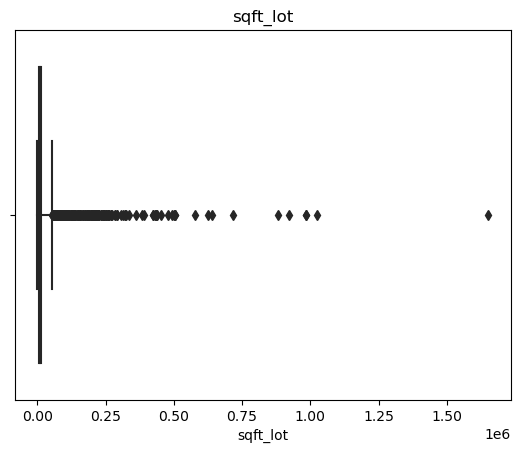

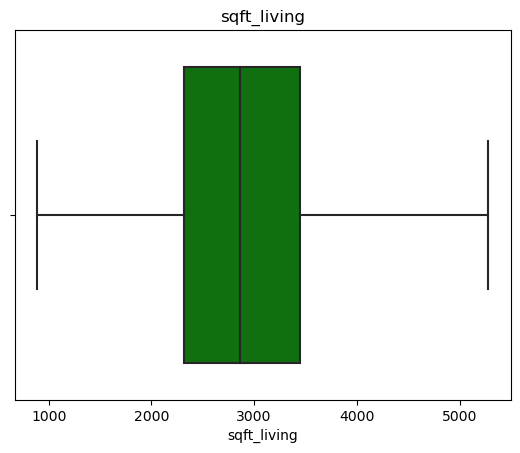

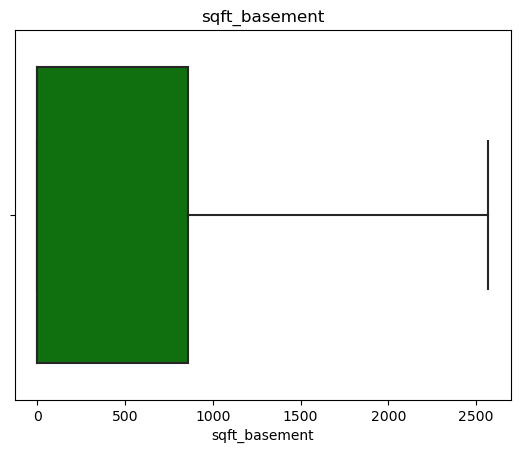

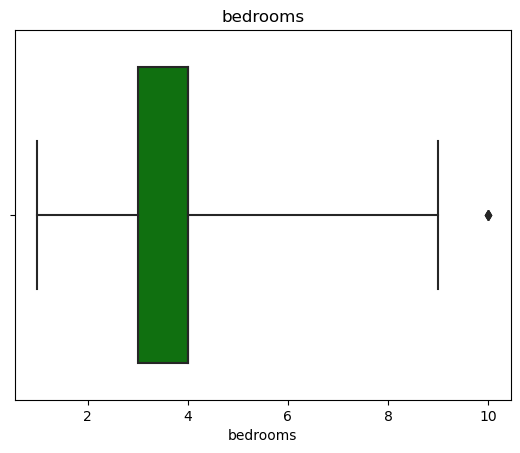

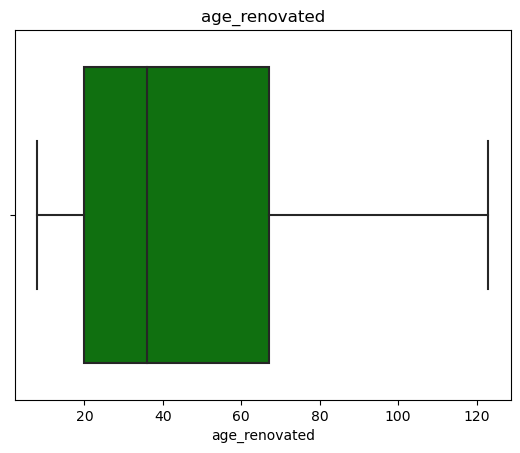

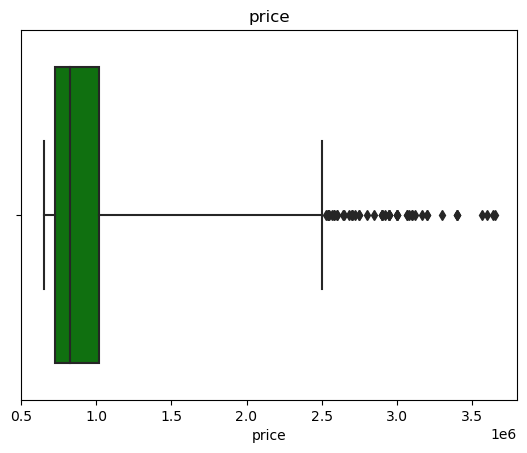

In [57]:
# Let's see if and how it affects the rest of the variables.
cols = ['sqft_lot', 'sqft_living', 'sqft_basement', 'bedrooms', 'age_renovated', 'price']

for col in cols:
    sns.boxplot(x=data_high_processed[col], whis=5, color='green')
    plt.title(col)
    plt.show()

The outlier in bedrooms remains. We have looked at these rows during preprocessing the complete dataset and considered them errors. Their removal does not impact the maximum values of the other columns. Hence we remove them also from the subset.

In [58]:
data_high_processed = data_high[data_high['bedrooms'] != 10]

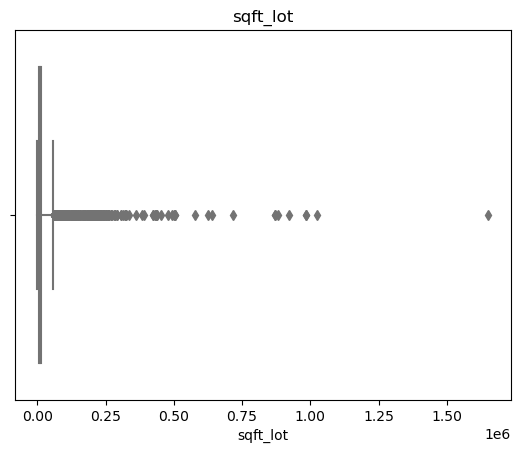

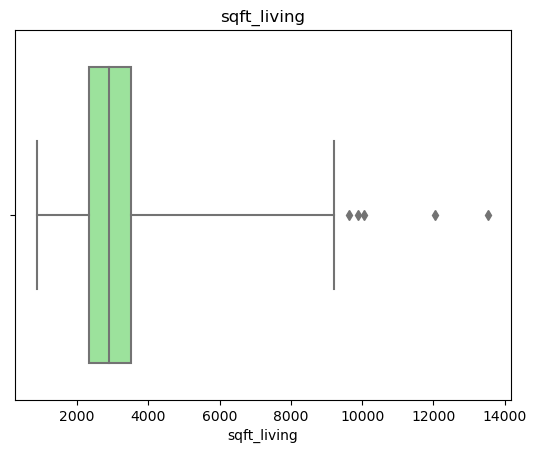

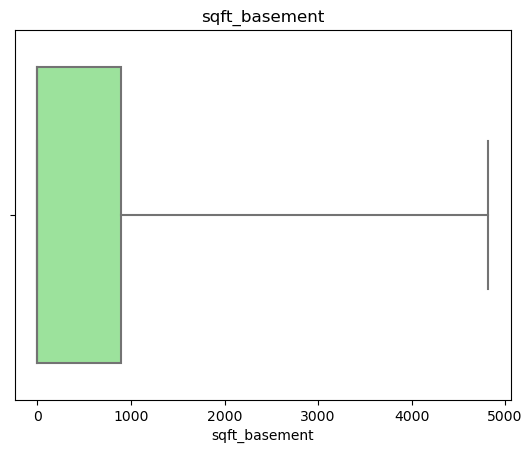

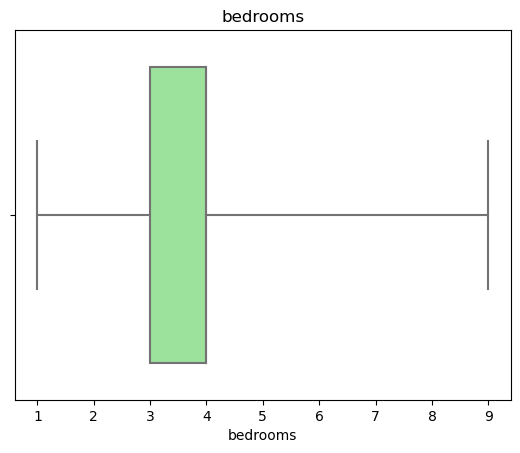

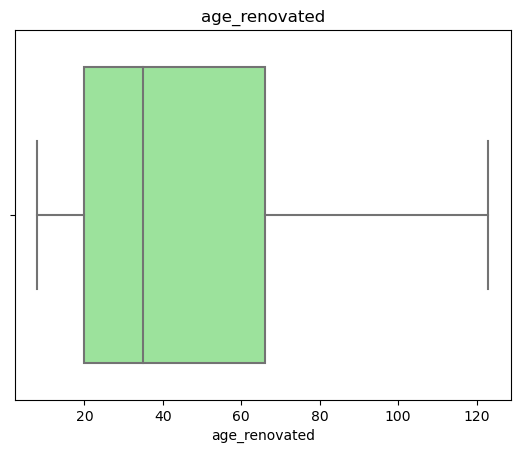

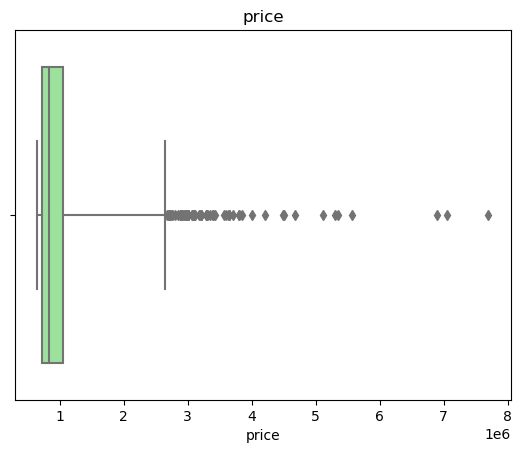

In [59]:
# Let's see if and how it affects the rest of the variables.
cols = ['sqft_lot', 'sqft_living', 'sqft_basement', 'bedrooms', 'age_renovated', 'price']

for col in cols:
    sns.boxplot(x=data_high_processed[col], whis=5, color='lightgreen')
    plt.title(col)
    plt.show()

By comparing the results of the models with and without the high-priced subset, we can gain insights into how the high-priced properties are affecting the overall trends and relationships in the data, and determine whether they are representative of the broader market or not.

In [60]:
# We check if the most important features have changed after preprocessing.
X = data_high_processed.drop(['price'], axis=1)
y = data_high_processed['price']

model = LinearRegression()
rfe = RFE(model, n_features_to_select=3)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
selected_features

Index(['lat', 'long', 'waterfront'], dtype='object')

In [61]:
X = data_processed.drop(['price'], axis=1)
y = data_processed['price']

model = LinearRegression()
rfe = RFE(model, n_features_to_select=3)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
selected_features

Index(['long', 'waterfront', 'grade'], dtype='object')

After preprocessing the 3 most important features are almost identical for both the entire dataset and the one of the high-priced properties (the five most important ones are completely identical). We will compare the metrics of the linear models below, but most likely work only with the entire dataset.

Interestingly, features related to the living space have disappeared from the list of important features. This was not due to removing outliers from 'sqft_living'. 

We conclude that the heatmap and the RFE algorithm are providing complementary information. The heatmap shows the pairwise correlations between features and the target variable, while the RFE algorithm takes into account the interactions between features and their combined effect on the model's performance. Therefore, it's important to consider both methods when interpreting our results.

The most important features are: `zipcode_category`/ `lat`and `long`, `waterfront`, `sqft_living` and `grade`.

## 6. Applying, Validating & Displaying Predictions

### Linear Regression

In [62]:
# Let's apply and validate the regression model of the full dataset processed.
models = [LinearRegression()]
model(models, data_processed)

TypeError: 'LinearRegression' object is not callable

In [ ]:
# Let's check the coefficients of each parameter
X = data_processed.drop('price', axis=1)
y = data_processed['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_lm = LinearRegression()
model_lm.fit(X, y)
coef = np.round(model_lm.coef_, 2)
df_coef = pd.DataFrame({'Title': X.columns, 'Coef': coef})
df_coef

Overall, these evaluation metrics indicate that the model is reasonably good, as it is able to explain a significant portion of the variation in the data. The errors in the predictions, as indicated by the RMSE and MAE, are not too bad since we are looking at property prices up to over 3M. 

In [ ]:
# And of the dataset with only those properties of 650K and above.
models = [LinearRegression()]
model(models, data_high_processed)

The model taking data_high_processed performs much worse than the one taking the entire dataset. Conclusion: the high-end properties are not significantly different from the lower-priced properties in terms of the features that are important for predicting property prices. We can run the other two models with the entire dataset only.

In [ ]:
# We check the skewness of the distributions.
skewness = skew(data_processed)
skewness_df = pd.DataFrame(zip(data_processed.columns, skewness), columns=['column', 'skewness'])
skewness_df

In [ ]:
# We transform those features that are skewed and where it is applicable without creating lots of NANs to see if it has an effect on the model's performance.
data_transformed = data_processed.copy()
columns_to_transform = ['sqft_lot']
data_transformed[columns_to_transform] = data_transformed[columns_to_transform].apply(np.log)
skewness = skew(data_transformed)
skewness

In [ ]:
y = data_transformed['price']
X = data_transformed.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_lm = LinearRegression()
model_lm.fit(X_train, np.log(y_train))
# We reverse the log transformation on the target.
y_pred_log = model_lm.predict(X_test)
predictions_lm = np.exp(y_pred_log)

r2_lm = r2_score(y_test, predictions_lm)
RMSE_lm = mean_squared_error(y_test, predictions_lm, squared=False)
MSE_lm = mean_squared_error(y_test, predictions_lm)
MAE_lm = mean_absolute_error(y_test, predictions_lm)

print("R2      =", round(r2_lm, 2))
print("Adj. R2 =", round(1 - (1 - r2_lm) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1), 2))
print("MSE     =", round(MSE_lm, 2))
print("RMSE    =", round(RMSE_lm, 2))
print("MAE     =", round(MAE_lm, 2))

Improving the skewness of the dataset has heavily improved the model's performance. 

In order to evaluate the performance of our model that predicts the prices of the properties in data_processed further, we are comparing the predicted prices with the original prices in dataset to assess its accuracy.

In [ ]:
print("Shape of data_transformed:", data_transformed.shape)
print("Shape of data_predictions:", predictions_lm.shape)

In [ ]:
# First we combine the original values and the predicted prices. For that we reset the indices to adapt the length of the datasets.
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

data_transformed = pd.concat([X_test, y_test], axis=1)

# We add the predicted value column to the dataset.
data_transformed['predicted_price'] = predictions_lm

# Format the price column to include commas.
data_transformed['price'] = data_transformed['price'].apply(lambda x: '{:,.0f}'.format(x))

# We set the floating-point formatter for the entire dataset to show all digits.
pd.options.display.float_format = '{:,.0f}'.format

data_property_prices = data_transformed[['price', 'predicted_price']].sort_values(by='predicted_price', ascending=False).reset_index(drop=True)
data_property_prices

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(y = predictions_lm, x = y_test, color='orange')

plt.xlabel('Property Price')
plt.ylabel('Predicted Property Price')
plt.show()

The distribution of this model in comparison to the baseline model hasn't changed much. By preprocessing we have removed the most extreme datapoints, and the overall distribution has aligned a bit more.

### KNN Regression

In [ ]:
# Let's apply and validate the KNN model of the full dataset processed.
models = [KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)]
model(models, data_processed)

In [ ]:
# Let's apply and validate the KNN model of the transformed dataset.
data_transformed = data_processed.copy()
columns_to_transform = ['sqft_lot']
data_transformed[columns_to_transform] = data_transformed[columns_to_transform].apply(np.log)

y = data_transformed['price']
X = data_transformed.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_knn = KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)
model_knn.fit(X_train, np.log(y_train))
# We reverse the log transformation on the target.
y_pred_log = model_knn.predict(X_test)
predictions_knn = np.exp(y_pred_log)

r2_knn = r2_score(y_test, predictions_knn)
RMSE_knn = mean_squared_error(y_test, predictions_knn, squared=False)
MSE_knn = mean_squared_error(y_test, predictions_knn)
MAE_knn = mean_absolute_error(y_test, predictions_knn)

print("R2      =", round(r2_knn, 2))
print("Adj. R2 =", round(1 - (1 - r2_knn) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1), 2))
print("MSE     =", round(MSE_knn, 2))
print("RMSE    =", round(RMSE_knn, 2))
print("MAE     =", round(MAE_knn, 2))

In [ ]:
# Actual price vs. predicted price with XGBoost
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
data_transformed = pd.concat([X_test, y_test], axis=1)
data_transformed['predicted_price'] = predictions_knn
data_transformed['price'] = data_transformed['price'].apply(lambda x: '{:,.0f}'.format(x))
pd.options.display.float_format = '{:,.0f}'.format
data_property_prices = data_transformed[['price', 'predicted_price']].sort_values(by='predicted_price', ascending=False).reset_index(drop=True)
data_property_prices

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(y = predictions_knn, x = y_test, color='orange')

plt.xlabel('Property Price')
plt.ylabel('Predicted Property Price')
plt.show()

### XGBoost

In [ ]:
# Let's apply and validate the XGBoost model of the full dataset processed.
models = [xgb.XGBRegressor(colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=1000, 
                           reg_alpha=0, reg_lambda=0.5, subsample=1, tree_method='hist')]
model(models, data_processed)

In [ ]:
# Let's apply and validate the XGBoost model of the transformed dataset.
data_transformed = data_processed.copy()
columns_to_transform = ['sqft_lot']
data_transformed[columns_to_transform] = data_transformed[columns_to_transform].apply(np.log)

y = data_transformed['price']
X = data_transformed.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=1000, 
                           reg_alpha=0, reg_lambda=0.5, subsample=1, tree_method='hist')
model_xgb.fit(X_train, np.log(y_train))
# We reverse the log transformation on the target.
y_pred_log = model_xgb.predict(X_test)
predictions_xgb = np.exp(y_pred_log)

r2_xgb = r2_score(y_test, predictions_xgb)
RMSE_xgb = mean_squared_error(y_test, predictions_xgb, squared=False)
MSE_xgb = mean_squared_error(y_test, predictions_xgb)
MAE_xgb = mean_absolute_error(y_test, predictions_xgb)

print("R2      =", round(r2_xgb, 2))
print("Adj. R2 =", round(1 - (1 - r2_xgb) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1), 2))
print("MSE     =", round(MSE_xgb, 2))
print("RMSE    =", round(RMSE_xgb, 2))
print("MAE     =", round(MAE_xgb, 2))

In [ ]:
# Actual price vs. predicted price with XGBoost
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
data_transformed = pd.concat([X_test, y_test], axis=1)
data_transformed['predicted_price'] = predictions_xgb
data_transformed['price'] = data_transformed['price'].apply(lambda x: '{:,.0f}'.format(x))
pd.options.display.float_format = '{:,.0f}'.format
data_property_prices = data_transformed[['price', 'predicted_price']].sort_values(by='predicted_price', ascending=False).reset_index(drop=True)
data_property_prices

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(y = predictions_xgb, x = y_test, color='orange')

plt.xlabel('Property Price')
plt.ylabel('Predicted Property Price')
plt.show()

### Model Comparison

In [ ]:
# Create a DataFrame to store the results
model_comparison = pd.DataFrame(columns=['Model', 'R2', 'Adj. R2', 'MSE', 'RMSE', 'MAE'])
model_comparison.loc[0] = ['Linear Regression', round(r2_lm, 2), round(1 - (1 - r2_lm) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1), 2), round(MSE_lm, 2), round(RMSE_lm, 2), round(MAE_lm, 2)]
model_comparison.loc[1] = ['KNN', round(r2_knn, 2), round(1 - (1 - r2_knn) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1), 2), round(MSE_knn, 2), round(RMSE_knn, 2), round(MAE_knn, 2)]
model_comparison.loc[2] = ['XGBoost', round(r2_xgb, 2), round(1 - (1 - r2_xgb) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1), 2), round(MSE_xgb, 2), round(RMSE_xgb, 2), round(MAE_xgb, 2)]

# Set formatting for the float columns
float_cols = ['R2', 'Adj. R2', 'MSE', 'RMSE', 'MAE']
model_comparison[float_cols] = model_comparison[float_cols].applymap('{:,.2f}'.format)

model_comparison

In [ ]:
# Split the data into input and target variables
X = cleaned.drop("price", axis=1)
y = cleaned["price"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# test_size = We give 30% for testing and 70% for testing
# random_state = it'll improve the model to divide always the model in the same way

model = LinearRegression() # We pick our model
model.fit(X_train,y_train) # We fit the training data into the model

# Calculate the feature importances
importances = np.abs(model.coef_)
feature_names = X.columns

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()